# Predictions

In [ ]:
!pip3 install sklearn

### Model for Gender prediction 

Importing the tensorflow framework and setting up the environment

In [88]:
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.callbacks as callbacks
from sklearn.model_selection import train_test_split
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data=pd.read_csv("dataset/dataset.csv")
data=data.drop("img_name",axis=1)
columns = ["age", "ethnicity", "gender"]
y = data.drop("pixels", axis=1)
x = data.drop(columns, axis=1)


In [5]:
num_pixels = len(x['pixels'][0].split(" "))
img_height = int(np.sqrt(len(x['pixels'][0].split(" "))))
img_width = int(np.sqrt(len(x['pixels'][0].split(" "))))
print(num_pixels, img_height, img_width)
x = pd.Series(x["pixels"])
x = x.apply(lambda x: x.split(' '))
x = x.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))
x = np.array(x)
x = np.stack(np.array(x), axis=0)
x = np.reshape(x, (-1, 48, 48))

# reshape data
x = x.reshape(-1, 48, 48, 1)
print("x shape: ", x.shape)


2304 48 48


/tmp/ipykernel_10805/4050057615.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = x.apply(lambda x: np.array(list(map(lambda z: np.int(z), x))))


x shape:  (23705, 48, 48, 1)


Splitting the data for test and train. x has been previosly been defined as the pixels column from the dataset(its the feature class), and y is the gender class(targetclass). 
- X_train - is the pixel data for training
- y_train - is the gender data for training
- X_test - is the pixel data for testing
- y_test - is the gender data for testing

the size of the training set has been set on 22% of the data, with a random number generator seed 37

In [6]:
y = y['gender']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=37
)

In [97]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

### The GenderModel

For our model we are using Keras CNN's.
 A Sequencial model is a linear stack of layers. In our case we have a depth of 10 layers(input and output included). as input we take a 48x48 image. the next layer 

Conv2D(2D convolution layer for blurring, sharpening, embossing, edge detection, and more by doing a convolution between a kernel and an image), with  a rectifier linear Unit Activation, and it 'zooms' in from the 48x48 image to ignore image margins.

Batch normalization is a method used to make artificial neural networks faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. so th ebatch normalization layer re-scales the data after the convolution takes place. It's usually a good practice to normalize the data in the network.

MaxPooling2D - Pooling layers are used to reduce the dimensions of the feature maps. Thus, it reduces the number of parameters to learn and the amount of computation performed in the network.This makes the model more robust to variations.

![title](presentation/maxPool.png)

The flattening layer transformes the pooled data from the pooling layer and transforms it into a long vector of input data that can be passed to the next dense layer for more processing.


![title](presentation/flattening.png)

![title](presentation/flattening2.png)

Finally our model has a dropout layer that helps to correct a possible overfitting.We randomly drop out some fraction of a layer's input units every step of training, making it much harder for the network to learn those spurious patterns in the training data. Instead, it has to search for broad, general patterns, whose weight patterns tend to be more robust. In our case we are dropping 30% ot the connections.

Our last layer produces the output hence the seize of one unit. As activation we are using a sigmod function that tends to work very well for Binary Classification.

In [18]:
inputShape = (48,48,1)

genderModel = tf.keras.Sequential([
    layers.InputLayer(input_shape=inputShape),
    layers.Conv2D(32,(3,3),activation='relu',input_shape = (32,32,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.3),
    layers.Dense(1, activation='sigmoid')
])

### Compiling the model
We chose to compile our model with the sgd optimizer. We did tests before with the adam optimizer, but we decided to stick with SGD because we got better results with it. Both SGM and ADAM are popular gradient descent algorithms, that can be found in use in most Tutorials and bibliography.

Since our Gender prediction is a Binary classification Problem, for  our loss funciton we decided to use BinaryCrossentropy. For metrics we are only using accuracy. 

https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/

![title](presentation/types_of_activation_&_loss.png)

In [21]:
genderModel.compile(optimizer='sgd',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


After training the model a couple of times, the training history graph tells me that i get at best 27% of prediction Success. Therefor a stoppin function is created after reaching that metric

In [22]:
class customStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<0.27):
            print("\nReached 0.2700 val_loss! cancelling training!")
            self.model.stop_training = True

### Overview of our model

In [23]:
genderModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

### Fit the data
fit the model with the training data, with a batch size of 64 Samples.The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters. Validation Split is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. we are using 10% of the dataset. As callbacks we are using earlyStopping and a custom function defined above.

In [ ]:
history = genderModel.fit(
    X_train, y_train, epochs=15, batch_size=64,validation_split=0.1, callbacks=[early_stopping],
)

### Evaluating our model's training

Gender Model Training history
Minimum validation loss: 0.2739487886428833


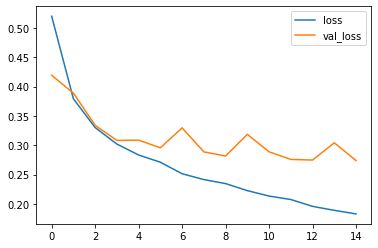

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Gender Model Training history")
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [ ]:
history_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.492931,0.763221,0.382539,0.834505
1,0.364418,0.837921,0.353724,0.839913
2,0.324069,0.856310,0.323495,0.860465
3,0.303246,0.867308,0.315849,0.858843
4,0.286295,0.875120,0.309241,0.868037


### Saving Model and weights to Disk

In [ ]:
from keras.models import model_from_json
gender_model_json = genderModel.to_json()
with open("models/gender/gender_model.json", "w") as json_file:
    json_file.write(gender_model_json)
# serialize weights to HDF5
genderModel.save_weights("models/gender/gender_model.h5")
print("Saved model to disk")

### load model from disk


In [19]:
from keras.models import model_from_json

json_file = open('models/gender/gender_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/gender/gender_model.h5")
print("Loaded model from disk")


Loaded model from disk


## Age Model

In [85]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=37
)

In [108]:
AgeModel = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(1, activation='relu')
])

In [109]:
AgeModel.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True

In [110]:
AgeModel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_3 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                      

In [106]:
class customStopping2(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<97):
            print("\nReached 97 val_loss so cancelling training!")
            self.model.stop_training = True

In [ ]:
history1 = AgeModel.fit(
    X_train, y_train, epochs=15, validation_split=0.1, batch_size=64, callbacks=[early_stopping,customStopping2()],
)

Age Model Training history- With stopping function
Minimum validation loss: 98.32288360595703


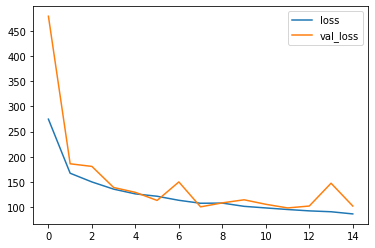

In [112]:
history_df_age = pd.DataFrame(history1.history)
history_df_age.loc[:, ['loss', 'val_loss']].plot();
print("Age Model Training history- With stopping function")
print("Minimum validation loss: {}".format(history_df_age['val_loss'].min()))

In [113]:
from keras.models import model_from_json
age_model_json = AgeModel.to_json()
with open("models/age/age_model.json", "w") as json_file:
    json_file.write(age_model_json)
# serialize weights to HDF5
AgeModel.save_weights("models/age/age_model.h5")
print("Saved model to disk")

Saved model to disk


## Ethnicity Model

In [115]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.22, random_state=37
)

The model has the usual layer types, differing only on the last layer activation type.
Pushing the "softmax" activation into the cross-entropy loss layer significantly simplifies the loss computation and makes it more numerically stable.

In [134]:
eth_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(48,48,1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.5),
    layers.Dense(5,activation='softmax')
])

We are still using adam as our otimizer,
The usage of SparceCategoriacCrossEntropy is because our data are integers, and not one-hot encoded[0,1]

In [135]:
eth_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [130]:
class customStopping3(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.79):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True

In [136]:
eth_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 6400)              0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [137]:
history2 = eth_model.fit(
    X_train, y_train, epochs=15, validation_split=0.1, batch_size=64,
)

Epoch 1/15
260/260 [==============================] - 17s 65ms/step - loss: 2.2678 - accuracy: 0.4191 - val_loss: 1.1734 - val_accuracy: 0.5014
Epoch 2/15
260/260 [==============================] - 16s 62ms/step - loss: 1.2663 - accuracy: 0.4998 - val_loss: 1.0476 - val_accuracy: 0.5900
Epoch 3/15
260/260 [==============================] - 17s 65ms/step - loss: 1.1874 - accuracy: 0.5313 - val_loss: 1.0369 - val_accuracy: 0.6101
Epoch 4/15
260/260 [==============================] - 19s 72ms/step - loss: 1.1516 - accuracy: 0.5518 - val_loss: 0.9125 - val_accuracy: 0.6668
Epoch 5/15
260/260 [==============================] - 17s 66ms/step - loss: 1.0959 - accuracy: 0.5749 - val_loss: 0.8968 - val_accuracy: 0.6679
Epoch 6/15
260/260 [==============================] - 17s 66ms/step - loss: 1.0678 - accuracy: 0.5879 - val_loss: 0.8619 - val_accuracy: 0.7015
Epoch 7/15
260/260 [==============================] - 16s 62ms/step - loss: 1.0369 - accuracy: 0.6012 - val_loss: 0.8318 - val_accuracy:

Ethnic Model Training history- No stopping function + ADAM + no_last_activation
Minimum validation loss: 0.7457478046417236


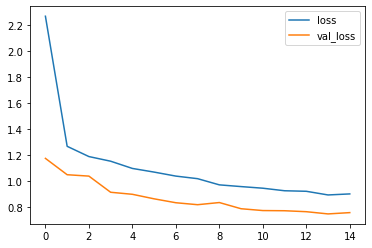

In [138]:
history_df_eth = pd.DataFrame(history2.history)
history_df_eth.loc[:, ['loss', 'val_loss']].plot();
print("Ethnic Model Training history- No stopping function + ADAM ")
print("Minimum validation loss: {}".format(history_df_eth['val_loss'].min()))

Ethnic Model Training history- No stopping function + ADAM + no_last_Activation
Maximum validation Accuracy: 0.7468901872634888


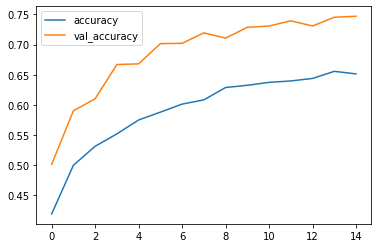

In [139]:
history_df_eth = pd.DataFrame(history2.history)
history_df_eth.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Ethnic Model Training history- No stopping function + ADAM ")
print("Maximum validation Accuracy: {}".format(history_df_eth['val_accuracy'].max()))

In [141]:
from keras.models import model_from_json
ethnic_model_json = eth_model.to_json()
with open("models/ethnia/eth_model.json", "w") as json_file:
    json_file.write(ethnic_model_json)
# serialize weights to HDF5
eth_model.save_weights("models/ethnia/eth_model.h5")
print("Saved model to disk")

Saved model to disk
